#Chapter 6, Example 3

In [10]:
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Create the figures folder if it doesn't exist
import os
if not os.path.isdir('figures'):
    print('creating the figures folder')
    os.makedirs('figures')

In [6]:
# Load and prepare the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Choose 12000 images for training, 2000 images for testing
train_data_subset = torch.utils.data.Subset(train_dataset, range(12000))
test_data_subset = torch.utils.data.Subset(test_dataset, range(2000))

# Use DataLoader to batch and shuffle the dataset
train_dataloader = DataLoader(train_data_subset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_data_subset, batch_size=128, shuffle=False)

In [7]:
# Build Model
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding='same')  # Same padding
        self.p1 = nn.MaxPool2d(2, 2)  # Max pooling over a (2, 2) window
        self.conv2 = nn.Conv2d(32, 64, 5, padding='same')  # Same padding
        self.p2 = nn.MaxPool2d(2, 2)  # Max pooling over a (2, 2) window
        self.flatten = nn.Flatten()
        self.d1 = nn.Linear(7 * 7 * 64, 1024)
        self.dropout = nn.Dropout(0.2)
        self.d2 = nn.Linear(1024, 10)

    def forward(self, x):
        conv1 = torch.relu(self.conv1(x))
        p1 = self.p1(conv1)
        conv2 = torch.relu(self.conv2(p1))
        p2 = self.p2(conv2)
        flatten = self.flatten(p2)
        d1 = torch.relu(self.d1(flatten))
        dropout = self.dropout(d1)
        out = torch.softmax(self.d2(dropout), dim=1)
        return conv1, p1, conv2, p2, out


# Create an instance of the model
model = MyModel()

# Code Explanation

This part of code defines a convolutional neural network (CNN) model designed for classifying MNIST images. Here's a detailed explanation of each part:

1. **Model Definition**:
    - `class MyModel(nn.Module)`: This line starts the definition of the new neural network model. The class inherits from `nn.Module`, PyTorch's base class for all neural network modules.

2. **Initialization Method**:
    - `self.conv1 = nn.Conv2d(1, 32, 5, padding='same')`: This line defines the first 2D convolutional layer. The layer takes in 1 input channel (since MNIST images are grayscale), outputs 32 feature maps, and uses a 5x5 square convolution kernel. The `padding='same'` argument means the output has the same width and height as the input.
    - `self.p1 = nn.MaxPool2d(2, 2)`: This defines a 2D max pooling operation, which reduces the spatial dimensions (width and height) of the input by taking the maximum value over a 2x2 window.
    - The next two lines (`self.conv2` and `self.p2`) define a second convolutional layer and max pooling operation, similar to the first two but with 64 output feature maps for the convolution.
    - `self.flatten = nn.Flatten()`: This defines a flattening operation, which converts the 2D image data into 1D data so it can be used in fully connected layers.
    - `self.d1 = nn.Linear(7 * 7 * 64, 1024)`: This defines the first fully connected layer, which takes in inputs of size `7 * 7 * 64` (the size of the flattened image data) and outputs 1024 features.
    - `self.dropout = nn.Dropout(0.2)`: This defines a dropout layer, which randomly sets a fraction `p=0.2` of the input units to 0 at each update during training, helping to prevent overfitting.
    - `self.d2 = nn.Linear(1024, 10)`: This defines the second fully connected layer, which takes in the 1024 features from the previous layer and outputs 10 features, likely corresponding to the 10 digit classes (0-9) in the MNIST dataset.

3. **Forward Method**:
    - `def forward(self, x)`: This method defines the forward pass of the model, i.e., how the model processes inputs to produce outputs.
    - The forward pass applies the layers defined in the constructor in order, with ReLU activations after the convolutional and first fully connected layers, and a softmax activation at the end. The softmax activation ensures the model outputs represent probabilities, i.e., they are non-negative and sum to 1.


In [8]:
# Choose an optimizer and loss function for training
loss_object = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Train step
def train_step(images, labels):
    optimizer.zero_grad()
    _,_,_,_,predictions = model(images)
    loss = loss_object(predictions, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), (predictions.argmax(dim=1) == labels).type(torch.float).mean().item()

# Test step
def test_step(images, labels):
    _,_,_,_,predictions = model(images)
    t_loss = loss_object(predictions, labels)
    return t_loss.item(), (predictions.argmax(dim=1) == labels).type(torch.float).mean().item()

# Main function: train and test the model
EPOCHS = 100
test_acc = []
for epoch in range(EPOCHS):
    train_loss = 0.0
    train_accuracy = 0.0
    test_loss = 0.0
    test_accuracy = 0.0
    train_steps = 0
    test_steps = 0

    for images, labels in train_dataloader:
        l, a = train_step(images, labels)
        train_loss += l
        train_accuracy += a
        train_steps += 1

    with torch.no_grad():
        for test_images, test_labels in test_dataloader:
            t_l, t_a = test_step(test_images, test_labels)
            test_loss += t_l
            test_accuracy += t_a
            test_steps += 1

    test_acc.append(test_accuracy / test_steps)
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch + 1,
                          train_loss / train_steps,
                          train_accuracy / train_steps,
                          test_loss / test_steps,
                          test_accuracy / test_steps))

Epoch 1, Loss: 2.3029399171788643, Accuracy: 0.07668439718954106, Test Loss: 2.3028341829776764, Test Accuracy: 0.08027343754656613
Epoch 2, Loss: 2.302833123410002, Accuracy: 0.08613142731817479, Test Loss: 2.302817165851593, Test Accuracy: 0.07666015625
Epoch 3, Loss: 2.3027859774041683, Accuracy: 0.08557734931720064, Test Loss: 2.3027292490005493, Test Accuracy: 0.08613281254656613
Epoch 4, Loss: 2.3027336851079414, Accuracy: 0.08973293442358361, Test Loss: 2.3026972115039825, Test Accuracy: 0.08916015643626451
Epoch 5, Loss: 2.302671807877561, Accuracy: 0.08912344863440128, Test Loss: 2.3026315420866013, Test Accuracy: 0.09501953143626451
Epoch 6, Loss: 2.3026043861470322, Accuracy: 0.08953900706577808, Test Loss: 2.302646741271019, Test Accuracy: 0.09394531254656613
Epoch 7, Loss: 2.3025577702420823, Accuracy: 0.09530141846613681, Test Loss: 2.3025365322828293, Test Accuracy: 0.09628906252328306
Epoch 8, Loss: 2.3025258601980005, Accuracy: 0.09325132978723404, Test Loss: 2.3025082

This part of code is used to train the model. Here is a detailed explanation of each part:

1. **Optimizer and Loss Function**:
    - `loss_object = nn.CrossEntropyLoss()`: This line defines the loss function that will be used during training. Cross-entropy loss is a common choice for classification problems.
    - `optimizer = torch.optim.SGD(model.parameters(), lr=0.001)`: This line defines the optimizer for training. The Stochastic Gradient Descent (SGD) optimizer is chosen, with a learning rate (`lr`) of 0.001. The optimizer will update `model.parameters()`, which are the weights and biases of the model.

2. **Training Step Function**:
    - `def train_step(images, labels)`: This function defines a single step of training. It takes a batch of images and labels, computes the model's predictions and the loss, backpropagates the loss to compute gradients, and updates the model's parameters using the optimizer. It returns the loss and the accuracy for the batch.

3. **Testing Step Function**:
    - `def test_step(images, labels)`: This function is similar to `train_step`, but it doesn't include the backpropagation and optimization steps, because the model isn't updated during testing.

4. **Main Training and Testing Loop**:
    - `for epoch in range(EPOCHS)`: This starts the main loop that trains and tests the model for a number of epochs.
    - Inside this loop, there are two inner loops. The first goes through the training data loader, performs a training step for each batch, and accumulates the training loss and accuracy. The second goes through the test data loader and performs a test step for each batch, similarly accumulating the test loss and accuracy.
    - After each epoch, the average training and test loss and accuracy are computed and printed. The test accuracy is also saved for later analysis.

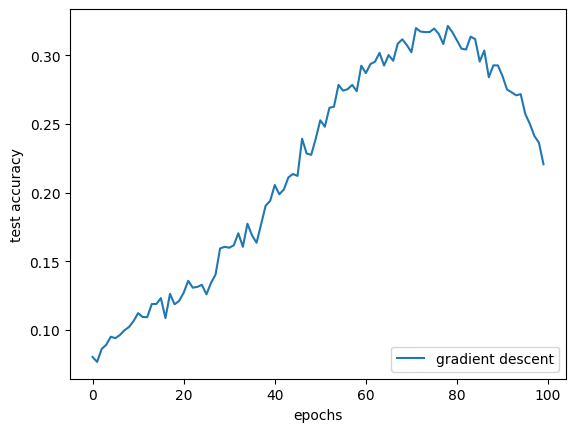

In [11]:
plt.figure()
plt.plot(np.arange(EPOCHS), test_acc, label='gradient descent')
plt.xlabel('epochs')
plt.ylabel('test accuracy')
plt.legend(loc='lower right')
plt.savefig('./figures/6.3_1.png')

(32, 1, 5, 5)


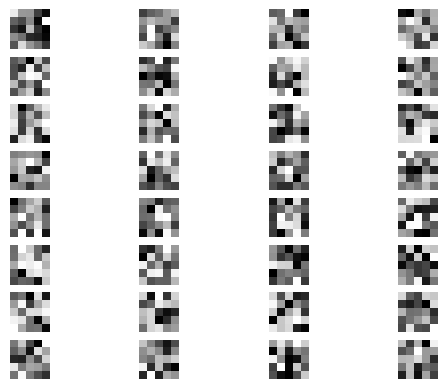

In [12]:
# Get filters learned at the first conv layer
filters_conv1 = model.conv1.weight.data.cpu().numpy()
print(filters_conv1.shape)
plt.figure()
plt.gray()
for i in range(32):
    plt.subplot(8, 4, i+1); plt.axis('off'); plt.imshow(filters_conv1[i, 0, :, :])
plt.savefig('./figures/6.3_2.png')


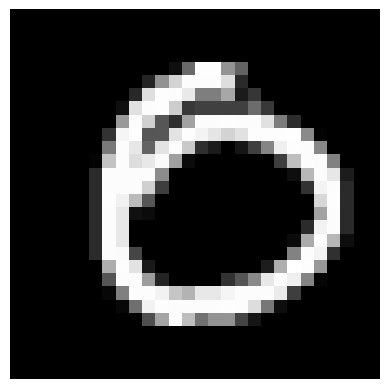

In [13]:
# Select and show a random sample
seed = 1
np.random.seed(seed)
ind = np.random.randint(0,2000)
x = test_data_subset[ind][0].unsqueeze(0)
conv1, p1, conv2, p2, out = model(x)

plt.figure()
plt.gray()
plt.axis('off')
plt.imshow(x.reshape(28,28))
plt.savefig('./figures/6.3_3.png')


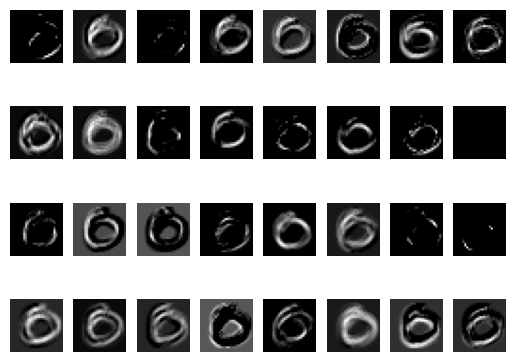

In [14]:
# Show feature maps at conv1
plt.figure()
plt.gray()
conv1 = conv1.detach().numpy()
for i in range(32):
    plt.subplot(4, 8, i+1); plt.axis('off'); plt.imshow(conv1[0,i,:,:])
plt.savefig('./figures/6.3_4.png')


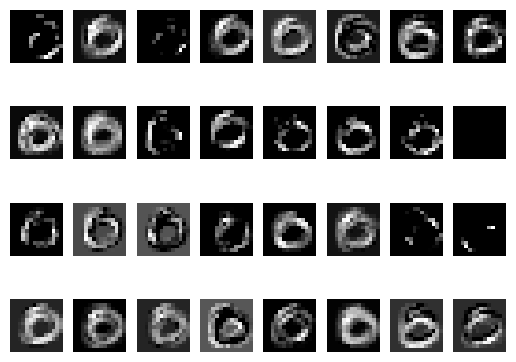

In [15]:
# Show feature maps at pooling1
plt.figure()
plt.gray()
p1 = p1.detach().numpy()
for i in range(32):
    plt.subplot(4, 8, i+1); plt.axis('off'); plt.imshow(p1[0,i,:,:])
plt.savefig('./figures/6.3_5.png')

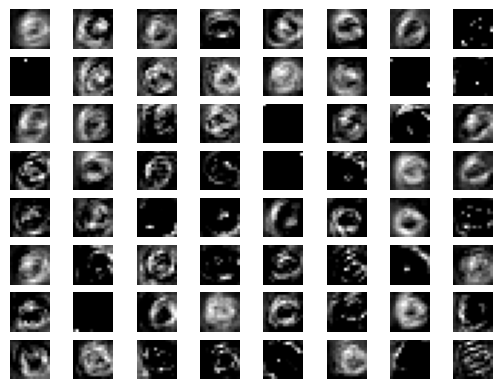

In [16]:
# Show feature maps at conv2
plt.figure()
plt.gray()
conv2 = conv2.detach().numpy()
for i in range(64):
    plt.subplot(8, 8, i+1); plt.axis('off'); plt.imshow(conv2[0,i,:,:])
plt.savefig('./figures/6.3_6.png')

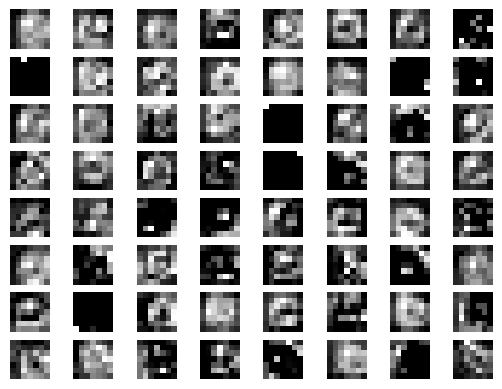

In [17]:
# Show feature maps at pooling2
plt.figure()
plt.gray()
p2 = p2.detach().numpy()
for i in range(64):
    plt.subplot(8, 8, i+1); plt.axis('off'); plt.imshow(p2[0,i,:,:])
plt.savefig('./figures/6.3_7.png')